In [1]:
#load data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py

data_dir = '/home/abdulla/codes/penn_uni_dataset/indoor_flying/'
event_data = h5py.File(data_dir + 'indoor_flying1_data.hdf5')
gt_data = h5py.File(data_dir + 'indoor_flying1_gt.hdf5')

OSError: Unable to create file (unable to open file: name = '/home/abdulla/codes/penn_uni_dataset/indoor_flying/indoor_flying1_data.hdf5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = 502)

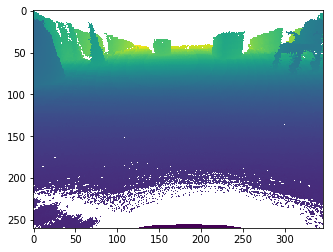

In [15]:
plt.imshow(gt_data['davis']['left']['depth_image_rect'][100])

In [16]:
print(event_data['davis']['left']['events'][1000])

[ 3.35000000e+02  2.34000000e+02  1.50464518e+09 -1.00000000e+00]


In [17]:
def ConcatenateEvent(event_list, time_steps, im_height=260, im_width=346):

    event_images_list = []

    event_iterator = 0
    for ts in time_steps:
        #print(event_iterator)
        event_image = np.zeros((im_height, im_width, 3), dtype=np.float64)
        counter_matrix = np.zeros((im_height, im_width))
        timestamp_matrix = np.zeros((im_height, im_width))
        print("start")
        for i in range(event_iterator, len(event_list)):
            event = np.copy(event_list[i])
            if event[2] > ts:
                event_image[:, :, 2] = np.zeros((im_height, im_width))
                event_image[:, :, 2] = np.divide(timestamp_matrix, counter_matrix, where=counter_matrix!=0)

                event_images_list.append(np.copy(event_image)) 
                event_iterator = i + 1
                break
            else:
                if event[3] > 0:
                    event_image[int(event[1]), int(event[0]), 0] = event_image[int(event[1]), int(event[0]), 0] + 1.0
                else:
                    event_image[int(event[1]), int(event[0]), 1] = event_image[int(event[1]), int(event[0]), 1] + 1.0
                
                counter_matrix[int(event[1]), int(event[0])] = counter_matrix[int(event[1]), int(event[0])] + 1.0                

                timestamp_matrix[int(event[1]), int(event[0])] = (ts - event[2]) + timestamp_matrix[int(event[1]), int(event[0])]


    return event_images_list     

In [33]:
time_steps = np.linspace(gt_data['davis']['left']['depth_image_rect_ts'][0], gt_data['davis']['left']['depth_image_rect_ts'][-1], 100)
event_images = ConcatenateEvent(event_data['davis']['left']['events'], time_steps)

start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start


In [36]:
def SelectFrames(images_list, images_ts, desired_timesteps, target_step=0.06):

    desired_frames = []
    images_iterator = 0

    for ts in desired_timesteps:
        for i in range(images_iterator, len(images_list)):
            if np.abs(images_ts[i] - ts) < target_step:
                desired_frames.append(images_list[i])
                images_iterator = i + 1
                break
            elif (images_ts[i] - ts) > 1:
                break

    return(desired_frames)

In [37]:
depth_images = SelectFrames(gt_data['davis']['left']['depth_image_rect'],  gt_data['davis']['left']['depth_image_rect_ts'], time_steps)
frame_images = SelectFrames(event_data['davis']['left'].keys())

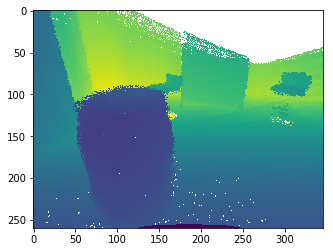

In [56]:
plt.imshow(depth_images[70])

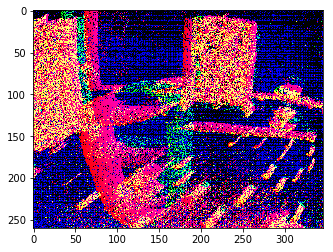

In [57]:
plt.imshow(event_images[70])

In [13]:
#Edge detectionb of depth image
import cv2

hf = h5py.File('indoor_flying_preprocessed.hdf5', 'r')
depth_images = hf['depth_images_timed']
def EdgeDetection(image_list, canny_threshold_1=100, canny_threshold_2=100):
    edge_images = []
    eroded_images = []
    truth_depth_images
    for image in image_list:
        mimic_img = np.copy(image)
        mimic_img[np.isnan(mimic_img)] = 0.0
        mimic_img = 255 * (mimic_img - np.min(mimic_img)) / (np.max(mimic_img) - np.min(mimic_img))
        dilation_kernel = np.ones((5,5), np.uint8) 
        dilated_img = cv2.dilate(np.uint8(mimic_img))
        edge_images.append(cv2.Canny(np.uint8(mimic_img), canny_threshold_1, canny_threshold_2))
    return edge_images, eroded_images, truth_edge_images

depth_edge_images = EdgeDetection(depth_images)

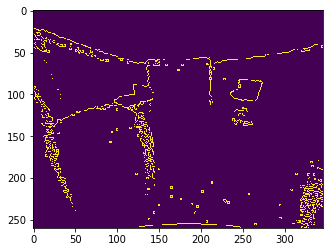

In [14]:
plt.imshow(depth_edge_images[30])

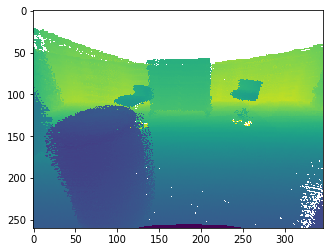

In [16]:
plt.imshow(depth_images[30])

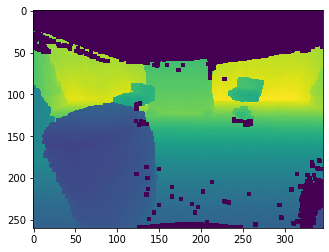

In [22]:
depth_img = np.copy(depth_images[30])
depth_img[np.isnan(depth_img)] = 0.0
depth_img = 255 * (depth_img - np.min(depth_img)) / (np.max(depth_img) - np.min(depth_img))
dilation_kernel = np.ones((5,5), np.uint8)
dilated_image = cv2.erode(depth_img, dilation_kernel)
plt.imshow(dilated_image)

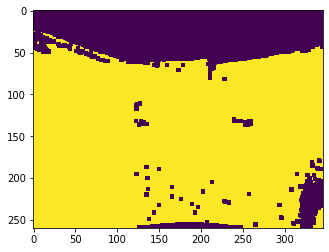

In [23]:
binary_img = np.copy(dilated_image)
binary_img[binary_img>0] = 1
plt.imshow(binary_img)

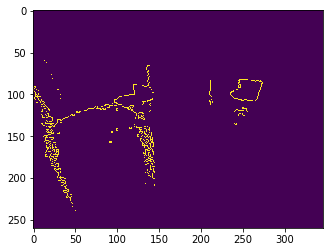

In [24]:
restored_depth_image = np.multiply(binary_img, depth_edge_images[30])
plt.imshow(restored_depth_image)

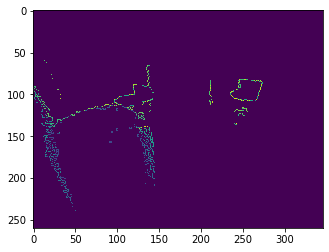

In [27]:
depth_img = np.copy(depth_images[30])
depth_img[np.isnan(depth_img)] = 0.0
truth_edge_image = np.multiply(restored_depth_image, depth_img)
plt.imshow(truth_edge_image)

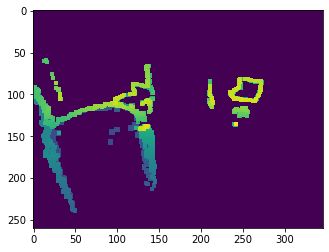

In [28]:
dilated_truth_image = cv2.dilate(truth_edge_image, dilation_kernel)
plt.imshow(dilated_truth_image)


In [62]:
#write data
hf = h5py.File('indoor_flying_preprocessed.hdf5', 'w')
hf.create_dataset('event_images', data=event_images)
hf.create_dataset('depth_images_timed', data=depth_images)
hf.create_dataset('time_steps', data=time_steps)
hf.close()
